# Basic DSP using Python
This is a basic example of how can a DSP for optical communications be implemented using python.
Note that most of the algorithms used here could never be used on a realistic DSP.
However, we hope that this code introduces you to the topic and perhaps you can improve on it.

### Notes:
- The experimental setup shown below consisted of a back-to-back transmission experiment. We generated a 10 Gbaud polarization multiplexed-QPSK signal using pulse pattern generators (PPG) driving a dual polarization IQ modulator. The signal was loaded with ASE noise to reach an OSNR of 12 dB and detected by a polarization-diverse coherent receiver. The trace was digitized by a real time oscilloscope operating at 50 GS/s.
- The data file contains the raw trace data from the oscilloscope as signed integers as well as the binary sequences used by the PPGs. Also, note that this setup implements natural mapping.

The content is licenced under the MIT licence

![](experimental_setup.png)

# Imports


In [15]:
%matplotlib inline
import pickle # required to load data files
import numpy as np # numeric stuff
import scipy.signal as sp # scipy signal processing
import matplotlib.pyplot as plt # plot stuff

# Load data from binary file

In [16]:
data = pickle.load( open( "scopedata_btb_osnr_12dB.pkl", "rb" ) )

# list the available data
for key in data.keys():
    print( "-", key )

- Rs_GHz
- ScopeRate_GHz
- ScopeSignal
- BinarySequences


# Create complex array from original data

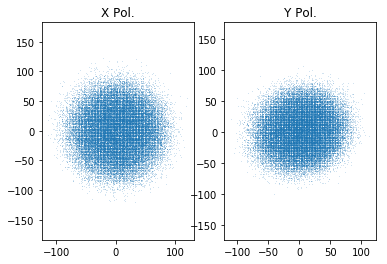

In [17]:
aux = np.array( data["ScopeSignal"], dtype = "double" ) # everything in a 4xN array converted to doubles

# create complex numbers
rsig = aux[ [ 0, 2 ], : ] + 1j * aux[ [ 1, 3 ], : ] # 2xN array of complex numbers
rsig = rsig[:,2::] # An arbitrary time shift to test the retiming algorithms

# a function to plot constellations
def plot_const( s, limit_axis = True ):
    plt.figure()
    plt.subplot( 1, 2, 1 ).set_title( "X Pol." )
    plt.plot( s[ 0, : ].real, s[ 0, : ].imag , ',', alpha = 0.2 )
    plt.axis( "equal" )
    if limit_axis:
        plt.axis( [ -1.5, 1.5, -1.5, 1.5 ] )
    plt.subplot( 1, 2, 2 ).set_title( "Y Pol." )
    plt.plot( s[ 1, : ].real, s[ 1, : ].imag , ',', alpha = 0.2 )
    plt.axis( "equal" )
    if limit_axis:
        plt.axis( [ -1.5, 1.5, -1.5, 1.5 ] )

rsig_initial = rsig
plot_const( rsig_initial[ :, :50000 ], False )

# Normalize data

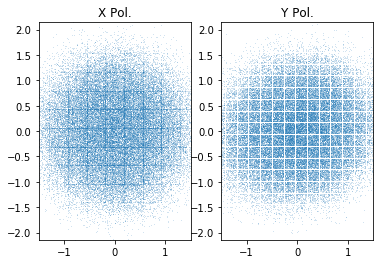

In [18]:

rsig_normalized = rsig_initial
# remove average value
rsig_normalized[ 0, : ] -= np.average( rsig_normalized[ 0, : ] )
rsig_normalized[ 1, : ] -= np.average( rsig_normalized[ 1, : ] )
power = np.average( np.abs( rsig_normalized )**2, 1 )
# normalize to average power
rsig_normalized[ 0, : ] /= np.sqrt( power[0] )
rsig_normalized[ 1, : ] /= np.sqrt( power[1] )
plot_const( rsig_normalized[ :, :50000 ] )

# Resample data

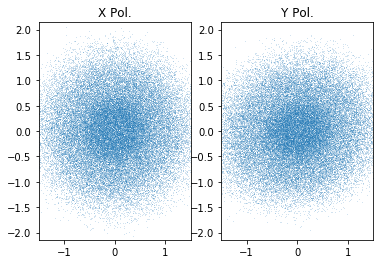

In [19]:

rsig = sp.resample_poly( rsig_normalized, 2, 5, 1 )
plot_const( rsig[ :, :50000 ] )

# Retiming - Clock Phase Recovery

## Clock phase estimation
#### S. J. Lee, “A new non-data-aided feedforward symbol timing estimator using two samples per symbol,” IEEE Communications Letters, vol. 6, no. 5, pp. 205–207, May 2002.

In [20]:
TimingEstimationLen = 16384 # length of the estimation filter in samples

# Lee estimator
pos = 1 + np.array( range( TimingEstimationLen ) )
aux = np.abs( rsig[ :, pos ] )**2 * np.exp( -1j * pos * np.pi ) + \
        np.real( rsig[ :, pos ] * np.conj( rsig[ :, pos - 1 ] ) ) * \
        np.exp( -1j * ( pos - 0.5 ) * np.pi )
eps = -np.angle( np.sum( aux, 1 ) ) / np.pi
print( "Clock phase on each polarization: ", eps )

Clock phase on each polarization:  [-0.00682775 -0.07231674]


## Clock phase alignment
#### L. Erup, F. M. Gardner, and R. A. Harris, “Interpolation in digital modems. II. Implementation and performance,” IEEE Transactions on Communications, vol. 41, no. 6, pp. 998–1008, Jun. 1993.

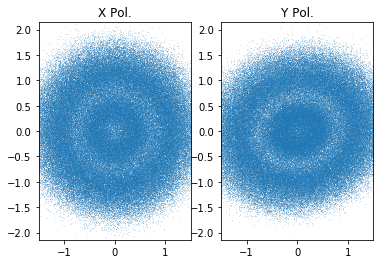

In [21]:
#============================
# Cubic Interpolator
#============================

# inputs to each of the taps - each tap sees a delayed or advanced version of the signal
tap_2_input = np.roll( rsig, 2, 1 )
tap_1_input = np.roll( rsig, 1, 1 )
tap_0_input = rsig
tap__1_input = np.roll( rsig, -1, 1 )

# compute tap coefficients - depend on the delay from the estimator
coef_2 = -eps**3 / 6 + eps / 6
coef_1 = eps**3 / 2 + eps**2 / 2 - eps
coef_0 = -eps**3 / 2 - eps**2 + eps / 2 + 1
coef__1 = eps**3 / 6 + eps**2 / 2 + eps / 3

# compute filter output
interpolator_output = np.zeros( rsig.shape, dtype = complex )
interpolator_output[ 0, : ] = \
    tap_2_input[ 0, : ] * coef_2[0] + \
    tap_1_input[ 0, : ] * coef_1[0] + \
    tap_0_input[ 0, : ] * coef_0[0] + \
    tap__1_input[ 0, : ] * coef__1[0]
interpolator_output[ 1, : ] = \
    tap_2_input[ 1, : ] * coef_2[1] + \
    tap_1_input[ 1, : ] * coef_1[1] + \
    tap_0_input[ 1, : ] * coef_0[1] + \
    tap__1_input[ 1, : ] * coef__1[1]
rsig = interpolator_output

# plot output
plot_const( interpolator_output[ :, ::2 ] )


    

# Polarization Demultiplexing - MIMO
#### S. J. Savory, “Digital filters for coherent optical receivers,” Optics Express, vol. 16, no. 2, p. 804, 2008.

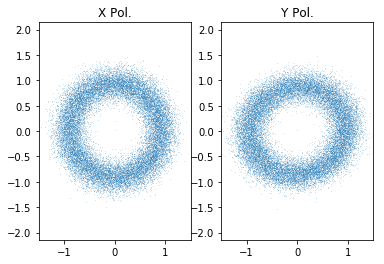

In [22]:
#=========================
# CMA MIMO Equalizer
#=========================
mu = 1e-3 # convergence parameter
ntaps = 5 # number of taps
npasses = 1 # number of passes

# initial equalizers
nsamp = rsig.shape[1] # the number of samples
hcma = np.zeros( ( 4, ntaps ), dtype = complex )
htaps = int( ( ntaps - 1 ) / 2 )
hcma[ [ 0, 3 ], htaps ] = 1

# cycle samples
s_out = np.zeros( rsig.shape, dtype = complex ) # a clean output
pos = np.array( range( -htaps, htaps + 1 ) ) # an array with the relative positions of the samples for each iteration
for p in range( 2 ):
    for s in range( htaps, nsamp - htaps ):
        # equalizer input
        s_in = rsig[ :, s + pos ]
        # equalizer output
        s_out[ 0, s ] = np.dot( hcma[ 0, : ], s_in[ 0, : ] ) + np.dot( hcma[ 1, : ], s_in[ 1, : ] )
        s_out[ 1, s ] = np.dot( hcma[ 2, : ], s_in[ 0, : ] ) + np.dot( hcma[ 3, : ], s_in[ 1, : ] )

        # update the equalizer at 1 sps
        if ( s%2 ) == 0:
            # equalizer error
            eq_err = 1 - np.abs( s_out[ :, s ] )**2
            # new equalizer
            hcma[ 0, : ] += mu * eq_err[0] * s_out[ 0, s ] * np.conj( s_in[ 0, : ] )
            hcma[ 1, : ] += mu * eq_err[0] * s_out[ 0, s ] * np.conj( s_in[ 1, : ] )
            hcma[ 2, : ] += mu * eq_err[1] * s_out[ 1, s ] * np.conj( s_in[ 0, : ] )
            hcma[ 3, : ] += mu * eq_err[1] * s_out[ 1, s ] * np.conj( s_in[ 1, : ] )

rsig = s_out[ :, ::2 ] # from this point on, we will work at 1 sps


# show the result
plot_const( rsig[ :, :25000 ] )  

# Carrier Recovery

## Carrier Frequency Recovery
### Frequency Offset Estimation
#### S. J. Savory, “Digital filters for coherent optical receivers,” Optics Express, vol. 16, no. 2, p. 804, 2008.

In [23]:
pos = np.array( range( 16384, 131072 ) )

FreqOffset = np.angle( np.sum( ( rsig[ :, pos + 1 ] * np.conj( rsig[ :, pos ] ) )**4, 1 ) ) / 4

print( "Normalized Frequency Offset for each polarization: ", FreqOffset )

Normalized Frequency Offset for each polarization:  [ 0.38835297  0.38873572]


### Frequency Offset Compensation

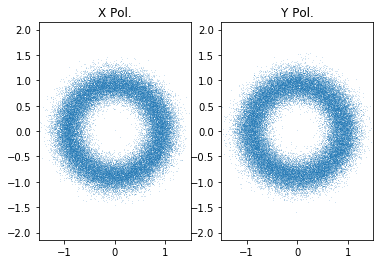

In [24]:
# initialize output vector
freq_output = np.zeros( rsig.shape, dtype = complex )

# normalized time
t = np.array( range( rsig.shape[1] ) )

# compensate phase shift on each sample
freq_output[ 0, : ] = rsig[ 0, : ] * np.exp( -1j * FreqOffset[ 0 ] * t )
freq_output[ 1, : ] = rsig[ 1, : ] * np.exp( -1j * FreqOffset[ 1 ] * t )

rsig = freq_output


# show the result
plot_const( rsig[ :, :50000 ] )

## Carrier Phase Recovery
### Carrier Phase Estimation
#### Viterbi

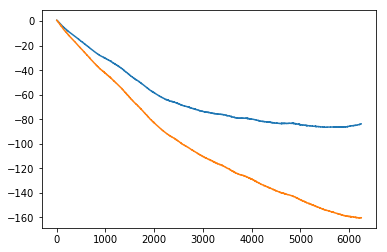

In [25]:
#=========================
# Estimation of the phase on each block
#=========================
BlockLen = 32

# compute number of blocks that we can compensate
nblocks = int( rsig.shape[1] / BlockLen )
nsamp = int( nblocks * BlockLen )

# reshape initial signal
block_angle = np.zeros( ( 2, nblocks ) )
for pol in range( 2 ):
    rsig_blocks = rsig[ pol, :nsamp ].reshape( ( nblocks, BlockLen ) )
    block_angle[ pol, : ] = np.unwrap( np.angle( np.sum( rsig_blocks**4, 1 ) ) ) / 4

# plot the estimated phase of each block
plt.figure()
plt.plot( block_angle[ 0, : ] )
plt.plot( block_angle[ 1, : ] )

## Carrier Phase Recovery

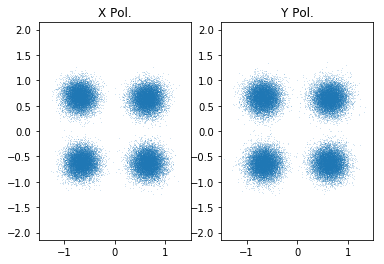

In [26]:
# Apply the estimated phase to the signal
carrier_output = np.zeros( ( 2, nsamp ), dtype = complex )
for pol in range( 2 ):
    phase_shift = ( np.outer( block_angle[ pol, : ], np.ones( ( 1, BlockLen ) ) ) ).reshape( ( 1, nsamp ) )
    carrier_output[ pol, : ] = rsig[ pol, :nsamp ] * np.exp( -1j * ( phase_shift + np.pi / 4 ) )

# Eliminate samples in the edges of the array
carrier_output = carrier_output[ :, 1024:-1024 ]

# show the result
plot_const( carrier_output[ :, :50000 ] )

# BER Counting

BER: 3.5362e-05 


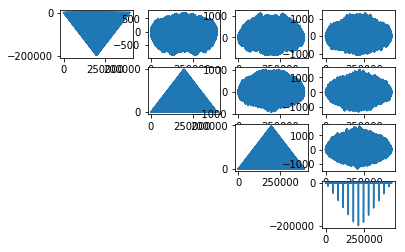

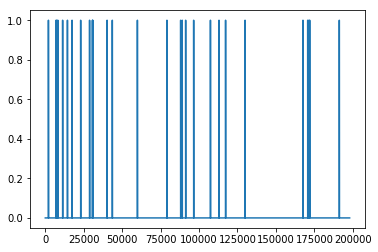

In [27]:
# demodulate - natural mapping
rsig_demod = np.vstack( ( carrier_output[ 0, : ].real, carrier_output[ 0, : ].imag, carrier_output[ 1, : ].real, carrier_output[ 1, : ].imag ) )
rsig_demod = np.sign( rsig_demod )

# transmitted sequences
tseq = data[ "BinarySequences" ]
nsamp = rsig_demod.shape[1]

# find the right sequence for each channel
seqs = list( range( 4 ) )
aligned_seqs = [[],[],[],[]]
maxpos = np.zeros((4,))
maxsgn = np.zeros((4,))
# cross correlate each received binary sequence with all the transmitted binary sequences
plt.figure("Correlation").clf()
for ch in range(4):
    #print( "Testing channel: ", ch )
    # try all sequences that are not assigned yet
    curmax = -10000000.0
    curseqno = -1
    for s in seqs:
        #print( "Comparing with sequence: ", s )
        # cross correlation
        tseqx = np.tile( np.array( tseq[s] ), ( int( np.ceil( nsamp / len( tseq[s] ) ) ), ) ) * 2 - 1
        xc = sp.correlate( rsig_demod[ ch, : ], tseqx )
        curmaxpos = np.argmax( np.abs( xc ) )
        maxval = np.abs( xc[ curmaxpos ] )
        if maxval > curmax:
            curmax = maxval
            aligned_seqs[ch] = np.sign( xc[ curmaxpos ] ) * np.roll( tseqx, int( curmaxpos + 1 ) )
            curseqno = s
        plt.subplot( 4, 4, ch * 4 + s + 1 )
        plt.plot( xc )
    # remove selected sequence
    seqs.remove( curseqno )

# compute errors
errors = np.zeros( rsig_demod.shape )
for ch in range(4):
    errors[ ch, : ] = np.abs( rsig_demod[ ch, : ] - aligned_seqs[ch][ :nsamp ] ) / 2
plt.figure( "Error Positions" )
plt.plot( np.sum( errors, 0 ), "-" )



# Compute BER
BER = np.sum( errors ) / errors.size
print( "BER: %.4e " % BER )